# 1. Overview

# 2. Forecasting

## 2.1 Import Libraries

In [1]:
# pip install prophet

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import logging
import itertools
import joblib
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, ParameterGrid

# Desactivar logs de Prophet
logging.getLogger('cmdstanpy').disabled = True

C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## 2.2 Define Global variables

In [3]:
input_data = 'data/weekly_data_combination.csv'
output_model_path = 'models/prophet_simple_asml_combination.pkl'
regressors = ['Close_Carl Zeiss Meditec', 'Close_Lam Research Corporation', 
              'Close_Tokyo Electron Limited', 'COVID_Period', 
              'Geopolitical_Tension', 'Trade_Sanctions', 
              'Tech_Regulation', 'New_Product_Launch']

## 2.3 Functions

## 2.4 Code

In [4]:
weekly_data_combination = pd.read_csv(input_data, sep=';')

# Ensure the 'Date' column is in datetime format
weekly_data_combination['Date'] = pd.to_datetime(weekly_data_combination['Date'])

# Set the 'Date' column as the index to make it a DatetimeIndex
weekly_data_combination.set_index('Date', inplace=True)

# Explicitly set the frequency of the Date index
weekly_data_combination = weekly_data_combination.asfreq('W')


weekly_data_combination.head()

,Close_ASML,Close_Carl Zeiss Meditec,Close_Lam Research Corporation,Close_Tokyo Electron Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict,Economic_Stimulus
Date,,,,,,,,,,,
2013-01-13,56.677277,26.057858,1.641578,7.480000,0,0,0,0,0,0,0
2013-01-20,57.336105,27.226339,1.674348,7.460000,0,0,0,0,0,0,0
2013-01-27,62.250641,27.674397,1.751687,7.406667,0,0,0,0,0,0,0
2013-02-03,67.013786,28.728661,1.822908,7.140000,0,0,0,0,0,0,0
2013-02-10,67.654839,29.343645,1.860047,6.853333,0,0,0,0,0,0,0


### 2.4.1 Train test split

In [5]:
train_data = weekly_data_combination[:-12]
train_data

,Close_ASML,Close_Carl Zeiss Meditec,Close_Lam Research Corporation,Close_Tokyo Electron Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict,Economic_Stimulus
Date,,,,,,,,,,,
2013-01-13,56.677277,26.057858,1.641578,7.480000,0,0,0,0,0,0,0
2013-01-20,57.336105,27.226339,1.674348,7.460000,0,0,0,0,0,0,0
2013-01-27,62.250641,27.674397,1.751687,7.406667,0,0,0,0,0,0,0
2013-02-03,67.013786,28.728661,1.822908,7.140000,0,0,0,0,0,0,0
2013-02-10,67.654839,29.343645,1.860047,6.853333,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-07-14,1075.397461,70.180000,109.826942,115.400002,0,0,0,0,0,0,0
2024-07-21,930.336243,67.750000,96.474556,100.919998,0,0,0,0,0,0,0
2024-07-28,886.747009,66.550003,90.711090,94.610001,0,0,0,0,0,0,0


In [6]:
test_data = weekly_data_combination[-12:]
test_data

,Close_ASML,Close_Carl Zeiss Meditec,Close_Lam Research Corporation,Close_Tokyo Electron Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict,Economic_Stimulus
Date,,,,,,,,,,,
2024-08-18,879.580017,68.449997,84.276657,95.220001,0,0,0,0,0,0,0
2024-08-25,926.179993,69.900002,86.024345,96.559998,0,0,0,0,0,0,0
2024-09-01,888.130005,72.644997,81.642670,89.629997,0,0,0,0,0,0,0
2024-09-08,811.479980,66.605000,75.787483,79.215000,0,0,0,0,0,0,0
2024-09-15,800.140015,63.835999,74.551239,82.000000,0,0,0,0,0,0,0
2024-09-22,803.039978,65.324997,76.603996,83.349998,0,0,0,0,0,0,0
2024-09-29,818.179993,70.800003,80.375000,85.470001,0,0,0,0,0,0,0
2024-10-06,832.409973,74.760002,81.408997,88.830002,0,0,0,0,0,0,0
2024-10-13,833.969971,72.779999,82.059998,86.790001,0,0,0,0,0,0,0


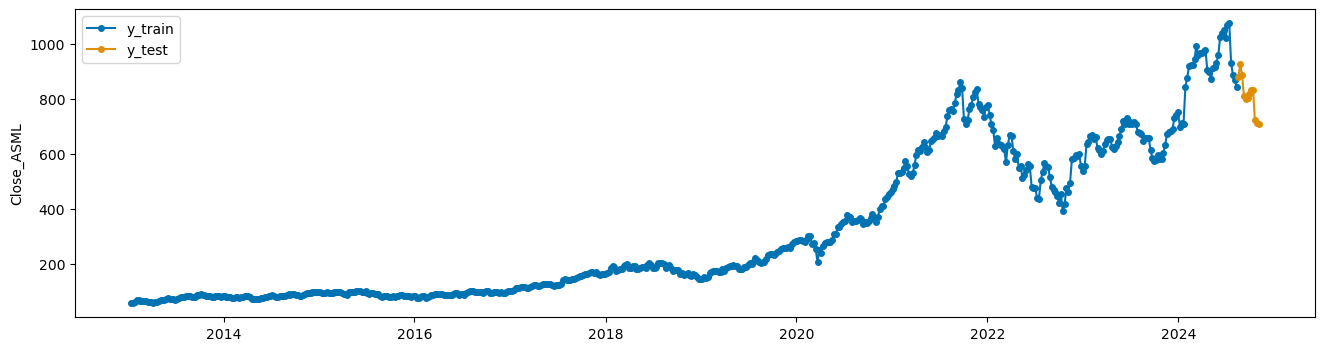

In [7]:
plot_series(train_data['Close_ASML'], test_data['Close_ASML'], labels=["y_train", "y_test"]);

### 2.4.2 SARIMA

Step 1: Log transformation (to stabilize variance)

In [10]:
log_train_data = np.log(train_data)

C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


Step 2: Check stationarity using the Augmented Dickey-Fuller test and Differencing if necessary

In [11]:
# Augmented Dickey-Fuller test
result = adfuller(log_train_data, autolag='AIC')
p_value = result[1]
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {p_value}')

if p_value > 0.05:
    print("The series is not stationary. Applying differencing.")
    # Differencing to achieve stationarity
    diff_log_train_data = log_train_data.diff().dropna()

    # Check stationarity again after differencing
    result_diff = adfuller(diff_log_train_data, autolag='AIC')
    p_value_diff = result_diff[1]
    print(f'ADF Statistic after differencing: {result_diff[0]}')
    print(f'p-value after differencing: {p_value_diff}')

    if p_value_diff > 0.05:
        print("The series is still not stationary.")
    else:
        print("The series is now stationary with differencing.")
    train_data_stationary = diff_log_train_data
else:
    print("The series is stationary with only log.")
    train_data_stationary = log_train_data

ValueError: x is required to have ndim 1 but has ndim 2

Plot the transformed data to visualize

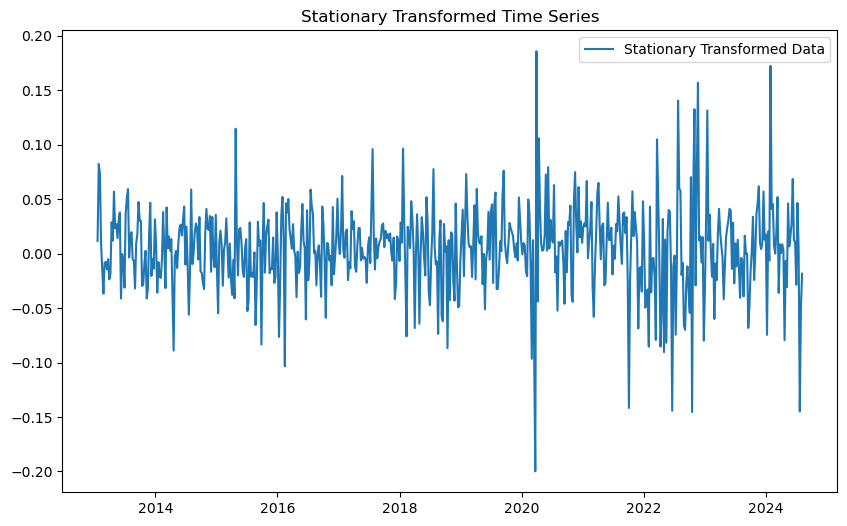

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(train_data_stationary, label='Stationary Transformed Data')
plt.title('Stationary Transformed Time Series')
plt.legend()
plt.show()

Initialize the SARIMA Model

In [27]:
sarima_model = SARIMAX(
    train_data_stationary,     # Training data that is stationary
    order=(1, 1, 1),           # ARIMA order (p, d, q)
    seasonal_order=(1, 1, 1, 52),  # Seasonal order (P, D, Q, s), here s=52 for weekly data
    enforce_stationarity=False,  # Allow the model to be non-stationary
    enforce_invertibility=False  # Allow the model to be non-invertible
)

In [28]:
# Fit the model to the training data
fitted_sarima = sarima_model.fit(disp=False)

In [29]:
# Generate predictions for the test set
y_pred_sarima = fitted_sarima.forecast(steps=len(test_data))

Now we have to revert the transformations

In [30]:
# Step 1: Revert the differencing
# 'last_original_value' is the last value before differencing was applied
last_original_value = log_train_data.iloc[-1]

# Add back the last original value to get the cumulative sum and revert differencing
y_pred_sarima_diff_reverted = np.r_[last_original_value, y_pred_sarima].cumsum()

# Remove the first value to match the length of test_data
y_pred_sarima_diff_reverted = y_pred_sarima_diff_reverted[1:]

# Step 2: Revert the logarithmic transformation
y_pred_sarima_reverted = np.exp(y_pred_sarima_diff_reverted)

# Convert the reverted predictions to a pandas Series
y_pred_sarima_reverted = pd.Series(y_pred_sarima_reverted, index=test_data.index)

Let's plot the data and predictions

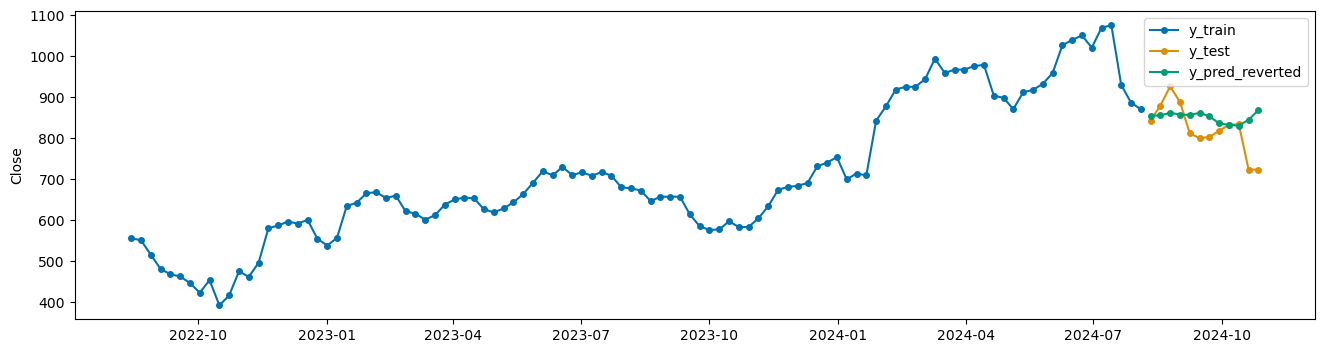

In [31]:
# Plot the training, test data, and predictions
plot_series(train_data[500:], test_data, y_pred_sarima_reverted, labels=["y_train", "y_test", "y_pred_reverted"]);

In [32]:
# Calculate MAPE for SARIMA model
mape_sarima = mean_absolute_percentage_error(test_data, y_pred_sarima_reverted) * 100
mape_sarima

6.129764284987541

In [33]:
# Calculate RMSE for SARIMA model
rmse_sarima = root_mean_squared_error(test_data, y_pred_sarima_reverted)
rmse_sarima

64.77053787082251

### 2.4.3 Prophet

Initialize the Prophet model

In [8]:
prophet_model = Prophet()

Fit the model to the data

First we need to modify the column names as is required by prophet

In [9]:
train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close_ASML':'y'})
train_data_prophet

,ds,y,Close_Carl Zeiss Meditec,Close_Lam Research Corporation,Close_Tokyo Electron Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict,Economic_Stimulus
0,2013-01-13,56.677277,26.057858,1.641578,7.480000,0,0,0,0,0,0,0
1,2013-01-20,57.336105,27.226339,1.674348,7.460000,0,0,0,0,0,0,0
2,2013-01-27,62.250641,27.674397,1.751687,7.406667,0,0,0,0,0,0,0
3,2013-02-03,67.013786,28.728661,1.822908,7.140000,0,0,0,0,0,0,0
4,2013-02-10,67.654839,29.343645,1.860047,6.853333,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
600,2024-07-14,1075.397461,70.180000,109.826942,115.400002,0,0,0,0,0,0,0
601,2024-07-21,930.336243,67.750000,96.474556,100.919998,0,0,0,0,0,0,0
602,2024-07-28,886.747009,66.550003,90.711090,94.610001,0,0,0,0,0,0,0
603,2024-08-04,870.549988,68.070000,85.226768,92.120003,0,0,0,0,0,0,0


In [10]:
test_data_prophet = test_data.reset_index(names="ds").rename(columns={'Close_ASML':'y'})
test_data_prophet

,ds,y,Close_Carl Zeiss Meditec,Close_Lam Research Corporation,Close_Tokyo Electron Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict,Economic_Stimulus
0,2024-08-18,879.580017,68.449997,84.276657,95.220001,0,0,0,0,0,0,0
1,2024-08-25,926.179993,69.900002,86.024345,96.559998,0,0,0,0,0,0,0
2,2024-09-01,888.130005,72.644997,81.642670,89.629997,0,0,0,0,0,0,0
3,2024-09-08,811.479980,66.605000,75.787483,79.215000,0,0,0,0,0,0,0
4,2024-09-15,800.140015,63.835999,74.551239,82.000000,0,0,0,0,0,0,0
5,2024-09-22,803.039978,65.324997,76.603996,83.349998,0,0,0,0,0,0,0
6,2024-09-29,818.179993,70.800003,80.375000,85.470001,0,0,0,0,0,0,0
7,2024-10-06,832.409973,74.760002,81.408997,88.830002,0,0,0,0,0,0,0
8,2024-10-13,833.969971,72.779999,82.059998,86.790001,0,0,0,0,0,0,0
9,2024-10-20,723.260010,67.094002,74.139999,81.540001,0,0,0,0,0,0,0


Add each regressor to the Prophet model

In [11]:
for regressor in regressors:
    prophet_model.add_regressor(regressor)

Fit the model

In [12]:
prophet_model.fit(train_data_prophet)

In [13]:
# Define the forecast horizon (e.g., 8 periods into the future)
# future = prophet_model.make_future_dataframe(periods=12, freq='W')

# Generate predictions
forecast = prophet_model.predict(test_data_prophet[[column for column in test_data_prophet if column != 'y']])
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,COVID_Period,COVID_Period_lower,COVID_Period_upper,Close_Carl Zeiss Meditec,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-08-18,468.657523,795.287821,855.168824,468.657523,468.657523,0.0,0.0,0.0,-21.817472,...,356.292030,356.292030,356.292030,0.241355,0.241355,0.241355,0.0,0.0,0.0,825.190908
1,2024-08-25,469.912778,809.697611,869.397633,469.912778,469.912778,0.0,0.0,0.0,-19.126388,...,369.364010,369.364010,369.364010,0.174330,0.174330,0.174330,0.0,0.0,0.0,839.451118
2,2024-09-01,471.168034,785.382815,844.752566,471.168034,471.168034,0.0,0.0,0.0,-14.031911,...,342.643258,342.643258,342.643258,0.806514,0.806514,0.806514,0.0,0.0,0.0,814.617806
3,2024-09-08,472.423289,729.934291,791.371594,472.423289,472.423289,0.0,0.0,0.0,-25.241630,...,287.047307,287.047307,287.047307,1.389301,1.389301,1.389301,0.0,0.0,0.0,760.859897
4,2024-09-15,473.678545,725.062963,786.167056,473.678545,473.682061,0.0,0.0,0.0,-30.380659,...,280.617571,280.617571,280.617571,0.842056,0.842056,0.842056,0.0,0.0,0.0,755.138172
5,2024-09-22,474.933801,737.834805,799.046416,474.894507,474.970306,0.0,0.0,0.0,-27.617205,...,295.210938,295.210938,295.210938,-1.123833,-1.123833,-1.123833,0.0,0.0,0.0,769.020905
6,2024-09-29,476.189056,769.618099,830.742248,476.095768,476.263032,0.0,0.0,0.0,-17.456062,...,326.520448,326.520448,326.520448,-3.538605,-3.538605,-3.538605,0.0,0.0,0.0,799.170899
7,2024-10-06,477.444312,785.436694,847.981541,477.296071,477.588534,0.0,0.0,0.0,-10.106642,...,344.173965,344.173965,344.173965,-5.004820,-5.004820,-5.004820,0.0,0.0,0.0,816.613456
8,2024-10-13,478.699567,784.393322,841.876268,478.489902,478.888080,0.0,0.0,0.0,-13.781359,...,340.249188,340.249188,340.249188,-4.965697,-4.965697,-4.965697,0.0,0.0,0.0,813.983058
9,2024-10-20,479.954823,729.497753,790.173618,479.660938,480.220440,0.0,0.0,0.0,-24.334084,...,283.986874,283.986874,283.986874,-4.027697,-4.027697,-4.027697,0.0,0.0,0.0,759.914000


Plot forecast components (trend, weekly, yearly components)

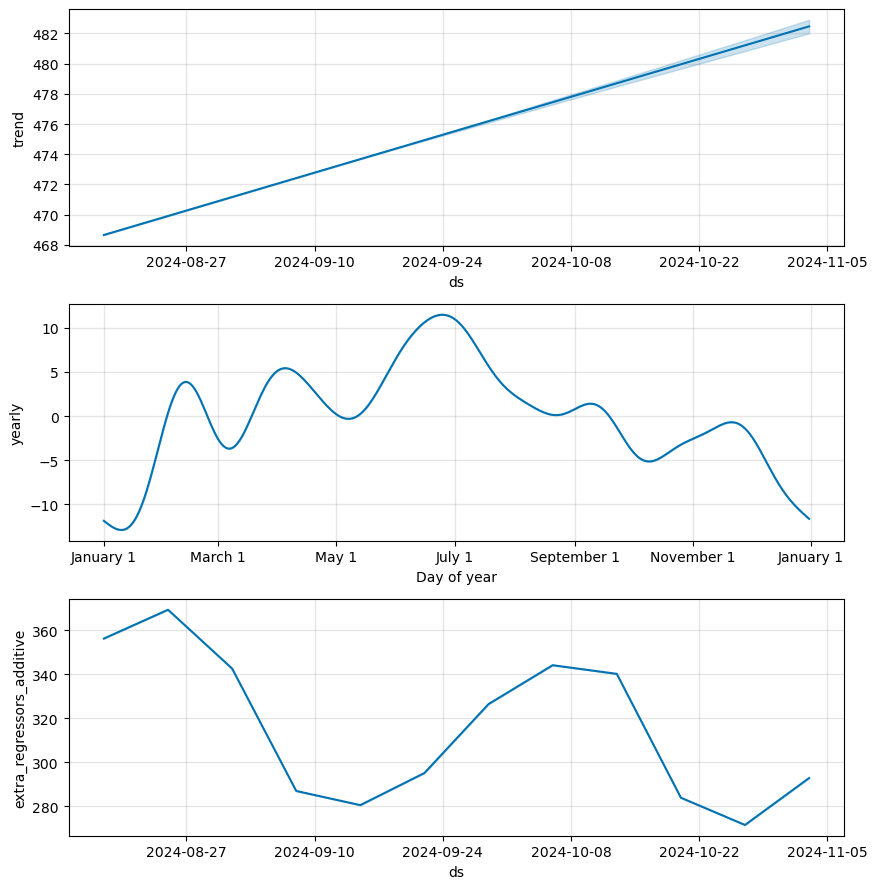

In [14]:
fig2 = prophet_model.plot_components(forecast)
plt.show()

In [15]:
# Return to the original DataFrame format with 'ds' as index and 'yhat' as 'Close'
forecast = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-12:]

forecast

,Close
ds,
2024-08-18,825.190908
2024-08-25,839.451118
2024-09-01,814.617806
2024-09-08,760.859897
2024-09-15,755.138172
2024-09-22,769.020905
2024-09-29,799.170899
2024-10-06,816.613456
2024-10-13,813.983058


In [16]:
# Ensure ds is the index of train_data_prophet 
train_data_prophet = train_data_prophet.set_index('ds')

# Ensure ds is the index of test_data_prophet 
test_data_prophet = test_data_prophet.set_index('ds')

Plot the forecast results

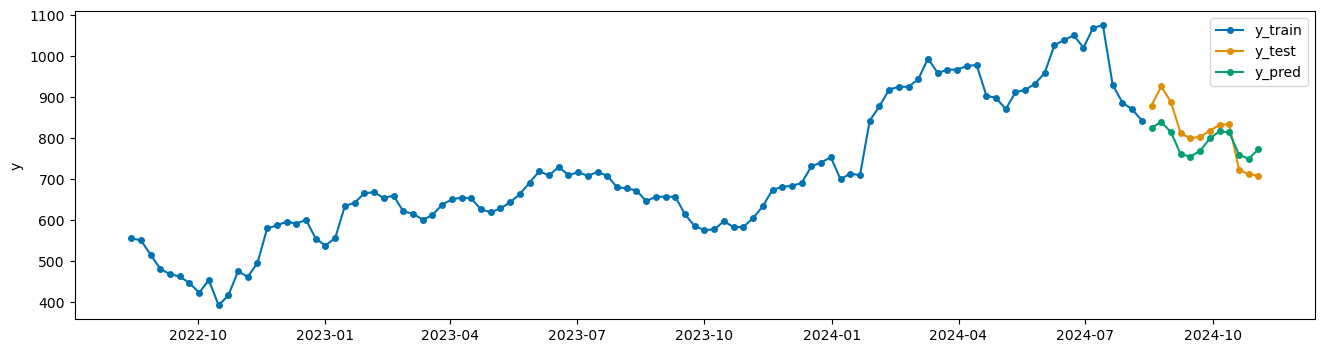

In [17]:
plot_series(train_data_prophet[['y']][500:], test_data_prophet[['y']], forecast, labels=["y_train", "y_test", "y_pred"]);

Now we are going to calculate the metrics of the model. The RMSE and the MAPE

In [21]:
mape_prophet = mean_absolute_percentage_error(test_data_prophet['y'], forecast) * 100
mape_prophet

5.503201770835897

In [22]:
rmse_prophet = root_mean_squared_error(test_data_prophet['y'], forecast)
rmse_prophet

49.64405896201648

In [42]:
mape_prophet = mean_absolute_percentage_error(test_data, forecast) * 100
mape_prophet

5.36336877115334

In [43]:
rmse_prophet = root_mean_squared_error(test_data, forecast)
rmse_prophet

55.013338778410336

### 2.4.6 XGboost

In [44]:
train_data_xgb_rf = create_features(train_data)
test_data_xgb_rf = create_features(test_data)

In [45]:
# Prepare X and y for the model
# Since we're not adding any features, we simply use the index as an integer sequence
X_train_xgb = train_data_xgb_rf.drop('Close', axis=1)
y_train_xgb = train_data_xgb_rf['Close']
X_test_xgb = test_data_xgb_rf.drop('Close', axis=1)
y_test_xgb = test_data_xgb_rf['Close']

In [46]:
# Initialize the XGBoost model
xgb_model = XGBRegressor(
    n_estimators=100,       # Number of trees
    learning_rate=0.1,      # Step size shrinkage
    max_depth=5,            # Maximum depth of trees
    random_state=42         # For reproducibility
)

In [47]:
# Train the model
xgb_model.fit(X_train_xgb, y_train_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [48]:
# Generate predictions
y_pred_xgb = xgb_model.predict(X_test_xgb)
y_pred_xgb = pd.DataFrame(y_pred_xgb, index=test_data.index, columns=['Close'])

In [49]:
# Evaluate the model's performance
rmse_xgb = root_mean_squared_error(y_test_xgb, y_pred_xgb)
rmse_xgb

70.56541789124057

In [50]:
mape_xgb = mean_absolute_percentage_error(y_test_xgb, y_pred_xgb)*100
mape_xgb

7.290917495795725

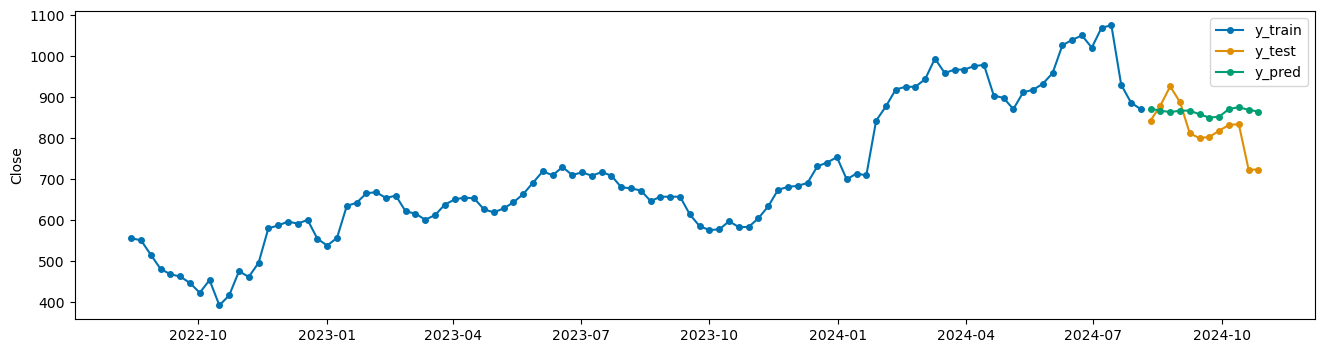

In [51]:
# Plot actual vs. predicted values
plot_series(y_train_xgb[500:], y_test_xgb, y_pred_xgb, labels=["y_train", "y_test", "y_pred"]);

### 2.4.7 Random Forest

In [52]:
# Prepare X and y for the model
# Since we're not adding any features, we simply use the index as an integer sequence
X_train_rf = train_data_xgb_rf.drop('Close', axis=1)
y_train_rf = train_data_xgb_rf['Close']
X_test_rf = test_data_xgb_rf.drop('Close', axis=1)
y_test_rf = test_data_xgb_rf['Close']

In [53]:
# Initialize the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,       # Number of trees
    max_depth=5,            # Maximum depth of trees
    random_state=42         # For reproducibility
)

In [54]:
# Train the model
rf_model.fit(X_train_rf, y_train_rf)

RandomForestRegressor(max_depth=5, random_state=42)

In [55]:
# Generate predictions
y_pred_rf = rf_model.predict(X_test_rf)

# Convert predictions to a DataFrame with the same index as the test data
y_pred_rf = pd.DataFrame(y_pred_rf, index=test_data.index, columns=['Close'])

In [56]:
# Evaluate the model's performance
rmse_rf = root_mean_squared_error(y_test_rf, y_pred_rf)
rmse_rf

95.4295610734148

In [57]:
mape_rf = mean_absolute_percentage_error(y_test_rf, y_pred_rf)*100
mape_rf

10.27227195307005

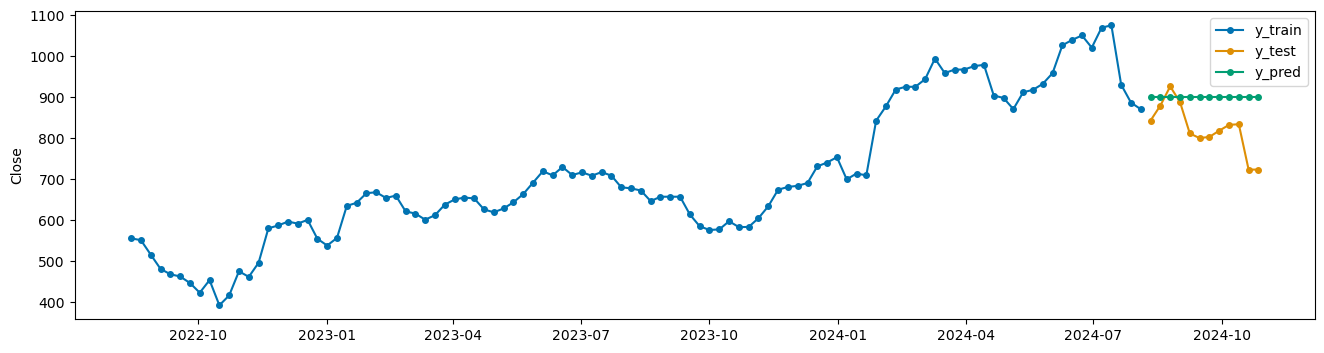

In [58]:
# Plot actual vs. predicted values
plot_series(y_train_rf[500:], y_test_rf, y_pred_rf, labels=["y_train", "y_test", "y_pred"]);

### 2.4.8 RMSE and MAPE comparison

In [59]:
# Create a dictionary to store RMSE and MAPE for each model
metrics = {
    "Model": ["Naive", "ETS (Additive)", "ETS (Multiplicative)", "SARIMA", "Prophet", "XGBoost", "Random Forest"],
    "RMSE": [
        rmse_naive,
        rmse_ets_add,
        rmse_ets_mul,
        rmse_sarima,
        rmse_prophet,
        rmse_xgb,
        rmse_rf
    ],
    "MAPE": [
        mape_naive,
        mape_ets_add,
        mape_ets_mul,
        mape_sarima,
        mape_prophet,
        mape_xgb,
        mape_rf
    ]
}

In [60]:
# Convert the dictionary to a pandas DataFrame
metrics_df = pd.DataFrame(metrics)

metrics_df

,Model,RMSE,MAPE
0,Naive,211.050910,24.891186
1,ETS (Additive),68.379467,6.933087
2,ETS (Multiplicative),53.602261,6.160616
3,SARIMA,64.770538,6.129764
4,Prophet,55.013339,5.363369
5,XGBoost,70.565418,7.290917
6,Random Forest,95.429561,10.272272


Our best model is Prophet as it has the lowest RMSE and MAPE

### 2.4.9 Fine-tunning

Let's investigate the following models after doing a fine-tunning: SARIMA, Prophet, and XGBoost

#### 2.4.9.1 SARIMA

We have commented the code below as the code takes 7 hrs to run

In [61]:
# # Define the range of values for the parameters (p, d, q) and seasonal parameters (P, D, Q, s)
# p = d = q = range(0, 3)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

# # Define variables to store the best model and its MAPE and RMSE
# best_mape = np.inf
# best_rmse = np.inf
# best_pdq = None
# best_seasonal_pdq = None
# best_model = None

# # Grid search
# total_combinations = len(pdq) * len(seasonal_pdq)  # Calculate total combinations
# current_combination = 0  # Counter for current combinations

# for param in pdq:
#     for seasonal_param in seasonal_pdq:
#         current_combination += 1
#         print(f"Testing combination {current_combination}/{total_combinations} -> order={param}, seasonal_order={seasonal_param}")

#         try:
#             # Fit the SARIMA model with current parameters
#             model = SARIMAX(train_data_stationary, 
#                             order=param, 
#                             seasonal_order=seasonal_param,
#                             enforce_stationarity=False, 
#                             enforce_invertibility=False)
#             results = model.fit(disp=False)
            
#             # Calculate the model's predictions
#             predictions = results.predict(start=0, end=len(train_data_stationary)-1)
            
#             # Calculate MAPE and RMSE
#             mape = np.mean(np.abs((train_data_stationary - predictions) / train_data_stationary)) * 100
#             rmse = np.sqrt(np.mean((train_data_stationary - predictions) ** 2))
            
#             # Update best model if its MAPE and RMSE are lower than the best found so far
#             if mape < best_mape and rmse < best_rmse:
#                 best_mape = mape
#                 best_rmse = rmse
#                 best_pdq = param
#                 best_seasonal_pdq = seasonal_param
#                 best_model = results

#         except Exception as e:
#             print(f"Error in combination {current_combination}: {e}")
#             continue

# print(f'\nBest SARIMA model: order={best_pdq}, seasonal_order={best_seasonal_pdq} with MAPE={best_mape} and RMSE={best_rmse}')


Looking at the results the SARIMA optimization doesn't converge therefore we won't take it into account.

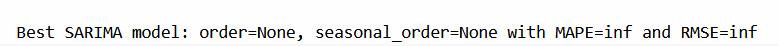

#### 2.4.9.2 Prophet

In [62]:
# Define the range of parameters
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 0.5, 1.0],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.1, 1.0, 10.0]
}

# Create combinations of parameters
grid = ParameterGrid(param_grid)

best_mape = float('inf')
best_params = None
best_model = None

for params in grid:
    model = Prophet(
        seasonality_mode=params['seasonality_mode'],
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale']
    )
    
    train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close':'y'})
    
    model.fit(train_data_prophet)

    # Generate predictions
    future = model.make_future_dataframe(periods=12, freq='W')
    forecast = model.predict(future)
    forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(test_data['Close'], forecast_filtered.loc[test_data.index])
    
    if mape < best_mape:
        best_mape = mape
        best_params = params
        best_model = model

print(f"Best parameters: {best_params} with MAPE: {best_mape}")

Best parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with MAPE: 0.049633752847964896


Let's now do again the prophet model with the best parameters

Initialize the Prophet model

In [63]:
prophet_model_best = Prophet(
        changepoint_prior_scale=0.01,
        holidays_prior_scale=0.1,
        seasonality_mode='multiplicative',
        seasonality_prior_scale=1.0
)

Fit the model to the data

First we need to modify the column names as is required by prophet

In [64]:
train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close':'y'})
train_data_prophet

,ds,y
0,2013-01-13,56.677265
1,2013-01-20,57.336109
2,2013-01-27,62.250618
3,2013-02-03,67.013779
4,2013-02-10,67.654816
...,...,...
599,2024-07-07,1069.428589
600,2024-07-14,1075.397461
601,2024-07-21,930.336243
602,2024-07-28,886.747009


In [65]:
prophet_model_best.fit(train_data_prophet)

In [66]:
# Define the forecast horizon (e.g., 8 periods into the future)
future_best = prophet_model_best.make_future_dataframe(periods=12, freq='W')

# Generate predictions
forecast_best = prophet_model_best.predict(future_best)

Plot forecast components (trend, weekly, yearly components)

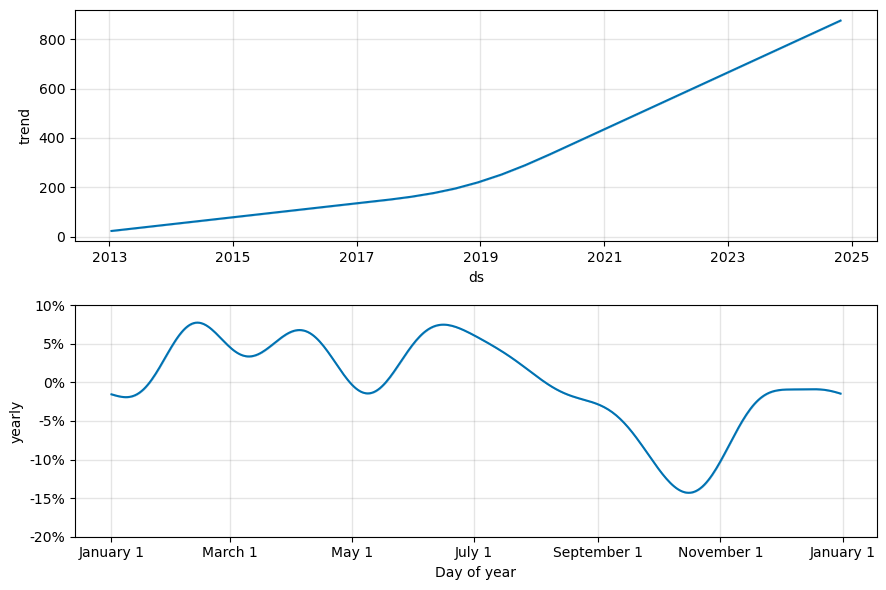

In [67]:
fig2 = prophet_model_best.plot_components(forecast_best)
plt.show()

In [68]:
# Return to the original DataFrame format with 'ds' as index and 'yhat' as 'Close'
forecast_best = forecast_best[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-12:]

forecast_best

,Close
ds,
2024-08-11,844.251927
2024-08-18,839.527763
2024-08-25,836.973894
2024-09-01,833.984329
2024-09-08,827.243020
2024-09-15,814.632026
2024-09-22,796.567892
2024-09-29,776.117112
2024-10-06,758.205932


In [69]:
# Ensure ds is the index of train_data_prophet 
train_data_prophet = train_data_prophet.set_index('ds')

Plot the forecast results

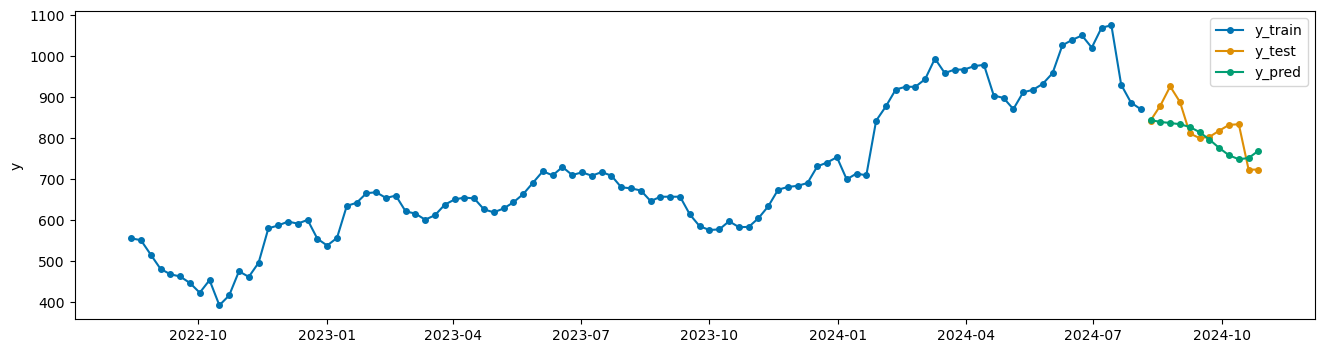

In [70]:
plot_series(train_data_prophet[500:], test_data, forecast_best, labels=["y_train", "y_test", "y_pred"]);

Now we are going to calculate the metrics of the model. The RMSE and the MAPE

In [71]:
mape_prophet_best = mean_absolute_percentage_error(test_data, forecast_best) * 100
mape_prophet_best

4.96337528479649

In [72]:
rmse_prophet_best = root_mean_squared_error(test_data, forecast_best)
rmse_prophet_best

50.40997738424668

#### 2.4.9.3 XGB

In [73]:
# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [50, 100, 150],       # Number of trees
    'learning_rate': [0.01, 0.1, 0.2],    # Step size shrinkage
    'max_depth': [3, 5, 7],               # Maximum depth of trees
    'random_state': [42]                  # For reproducibility
}

In [74]:
# Initialize the XGBoost model
xgb_model = XGBRegressor()

In [75]:
# Set up the GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    scoring='neg_mean_absolute_error',  # Use MAE as the scoring metric
    cv=3,                               # 5-fold cross-validation
    n_jobs=-1,                          # Use all available cores
    verbose=1                           # Show the training process
)

In [76]:
# Fit the GridSearchCV to the training data
grid_search.fit(X_train_xgb, y_train_xgb)

# Get the best parameters found
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Get the best model
best_xgb_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_xgb_best = best_xgb_model.predict(X_test_xgb)

# Convert predictions to a DataFrame with the same index as test_data
y_pred_xgb_best = pd.DataFrame(y_pred_xgb_best, index=test_data.index, columns=['Close'])


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters found: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150, 'random_state': 42}


In [77]:
# Evaluate the model's performance
rmse_xgb = root_mean_squared_error(y_test_xgb, y_pred_xgb_best)
rmse_xgb

73.26363518549587

In [78]:
mape_xgb = mean_absolute_percentage_error(y_test_xgb, y_pred_xgb_best)*100
mape_xgb

7.565376390757217

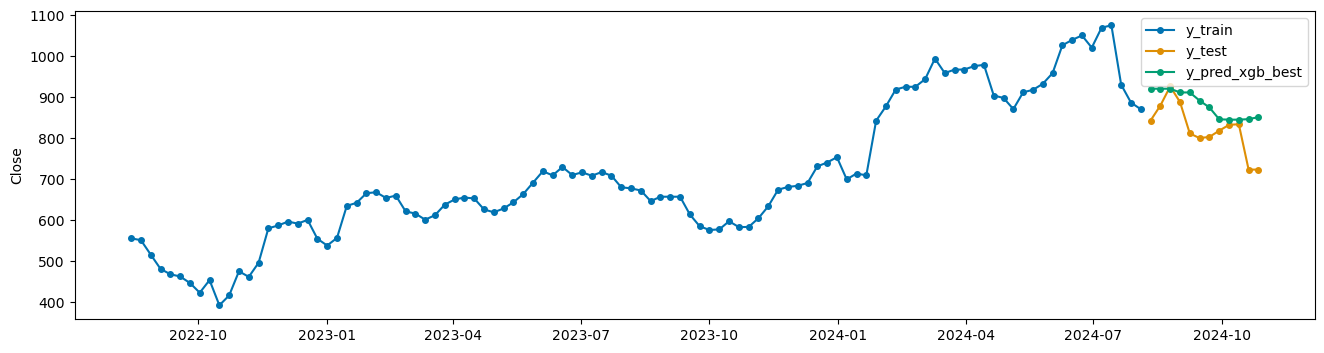

In [79]:
# Plot actual vs. predicted values
plot_series(y_train_xgb[500:], y_test_xgb, y_pred_xgb_best, labels=["y_train", "y_test", "y_pred_xgb_best"]);

#### 2.4.9.4 Results

The final chosen model is the prophet as the MAPE improved from 5.36 to 4.96 and RMSE 55.01 to 50.41

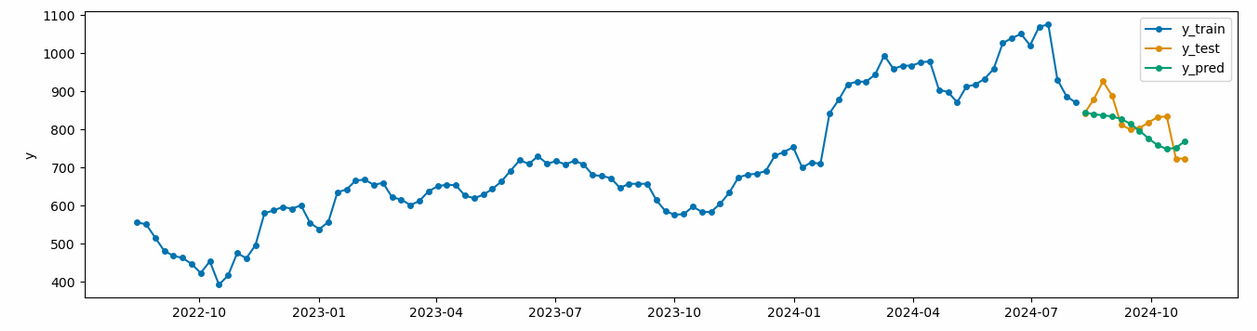

#### 2.4.9.5 Save the best model

In [80]:
joblib.dump(prophet_model_best, output_model_path)

['models/prophet_simple_asml_model.pkl']